# GNN on EEG 1

#### Graph
- nodes: EEG electrodes
- edges: G1 = 4 neerest neighbors, G2 = edge if distance < 30
- attributes: extracted features

In [2]:
import sys
sys.path.append('../')

In [3]:
from pathlib import Path
import pandas as pd
from sklearn import neighbors
from scipy import stats
import numpy as np

root = Path('../EEGDataset/')
elec_coord_file = root/'electrode_coordinates.csv'
elec_coord = pd.read_csv(elec_coord_file, index_col=0)

In [4]:
# graph 1 : 4 neerest neighbors
A1 = neighbors.kneighbors_graph(elec_coord,4).toarray()
A1 += A1.T
A1 = (A1>0).astype(int)

# graph 2 : distance threshold
positions = elec_coord.to_numpy()
distances = np.linalg.norm(positions[:,None,:]-positions[None,:,:], axis=-1)
A2 = (distances<30).astype(int)

In [5]:
# Choose a graph
A = A2

edge_index = []
for i in range(len(A)):
    for j in range(i, len(A)):
        if A[i,j] > 0:
            edge_index.append([i,j])

edge_index = np.array(edge_index).T

In [6]:
labels = elec_coord.index.values
Xn = elec_coord['x'].values
Yn = elec_coord['y'].values
Zn = elec_coord['z'].values

Xe = []
Ye = []
Ze = []
for e in edge_index.T:
    Xe += [Xn[e[0]], Xn[e[1]], None]
    Ye += [Yn[e[0]], Yn[e[1]], None]
    Ze += [Zn[e[0]], Zn[e[1]], None]

In [7]:
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=Xe, y=Ye, z=Ze,
    mode='lines',
    line=dict(color='rgb(0,0,0)', width=1),
    hoverinfo='none',
)

trace2 = go.Scatter3d(
    x=Xn, y=Yn, z=Zn,
    mode = 'markers',
    name = 'electrodes',
    marker = dict(
        symbol='circle',
        size=2,
        line=dict(color='rgb(50,50,50)',width=0.5),
    ),
    text=labels,
    hoverinfo='text',
)

axis=dict(
    showbackground=False,
    showline=False,
    showgrid=False,
    showticklabels=False,
    title='',
)

layout = go.Layout(
    scene = dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis),
    )
)

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
fig.show()

#### Data

Features:
- mean
- standard deviation (std)
- ptp
- variance (var)
- minimum (minim)
- maximum (maxim)
- minimum argument (argminim)
- maximum argument (argmaxim)
- root mean square (rms)
- absolute difference signal (abs_diff_signal)
- skewness
- kurtosis


In [1]:
# Extract features

def extract_features(X, features):

    X_feat = [feat(X) for feat in features]
    X_feat = np.stack(X_feat, axis=-1)

    return X_feat 


def mean(X):
    return np.mean(X, axis=-1)

def std(X):
    return np.std(X, axis=-1)

def ptp(X):
    return np.ptp(X, axis=-1)

def var(X):
    return np.var(X, axis=-1)

def minim(X):
    return np.min(X, axis=-1)

def maxim(X):
    return np.max(X, axis=-1)

def argminim(X):
    return np.argmin(X, axis=-1)

def argmaxim(X):
    return np.argmax(X, axis=-1)

def rms(X):
    return np.sqrt(np.mean(X**2, axis=-1))

def abs_diff_signal(X):
    return np.sum(np.abs(np.diff(X, axis=-1)), axis=-1)

def skewness(X):
    return stats.skew(X, axis=-1)

def kurtosis(X):
    return stats.kurtosis(X, axis=-1)


In [2]:
from utils.dataset import EEGDataset

# Load data
eeg_dir  = root/'raw'
subjects = ['sub-01']
eeg_data = EEGDataset(eeg_dir, subjects)

X, y = [], []
for d in eeg_data:
    X.append(d['eeg'])
    y.append(d['label'])

X = np.array(X)
y = np.array(y)


# select features to extract
features = [mean, std, ptp, var, minim, maxim, argminim, argmaxim, rms, abs_diff_signal, skewness, kurtosis]
X_feat = extract_features(X, features)
print(X_feat.shape) # (n_samples, n_channels, n_features)

ModuleNotFoundError: No module named 'utils'

In [1]:
import torch 

def data_split(graph_data, lengths):

    assert sum(lengths) == 1, 'parts of length should sum to 1'

    size_ = len(graph_data)
    indices = np.arange(size_)
    np.random.shuffle(indices)

    splits = np.cumsum([int(size_*l) for l in lengths])[:-1]
    indices = np.split(indices, splits)

    datas  = [graph_data[ids].copy() for ids in indices]

    return datas


def train(dataloader, model, loss_fn, optimizer, device='cpu', clip=None):
    model.train()
    #num_batches = len(dataloader)

    tra_loss = 0
    for batch in dataloader:

        # compute prediction error
        pred = model(batch.to(device)).squeeze()
        loss = loss_fn(pred, batch.y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)   
        optimizer.step()

        tra_loss += loss.item()

    return tra_loss / len(dataloader)

def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):

            y = batch.y.to(device)
            pred = model(batch.to(device)).squeeze()
            val_loss += loss_fn(pred, y).item()
            correct += ((pred>0.5) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss    


class StandardScaler():
    def __init__(self, mean=0, std=0, dataset=None):
        self.mean = mean
        self.std = std
        if dataset is not None:
            self.fit(dataset)

    def fit(self, dataset):
        X = []
        for data in dataset:
            X.append(data.x)

        X = torch.stack(X)
        self.mean = torch.mean(X, axis=0)
        self.std  = torch.std(X, axis=0)

    def transform(self, dataset):
        slices = dataset.slices['x'] 
        for i, _ in enumerate(slices[:-1]):
            idx1, idx2 = slices[i], slices[i+1]
            dataset._data.x[idx1:idx2] = (dataset._data.x[idx1:idx2] - self.mean) / (self.std+1e-20)

    def fit_transform(self, dataset):
        self.fit(dataset)
        self.transform(dataset)


Number of parameters for model:  1025
portion of true samples :  0.5


Text(0, 0.5, 'train loss')

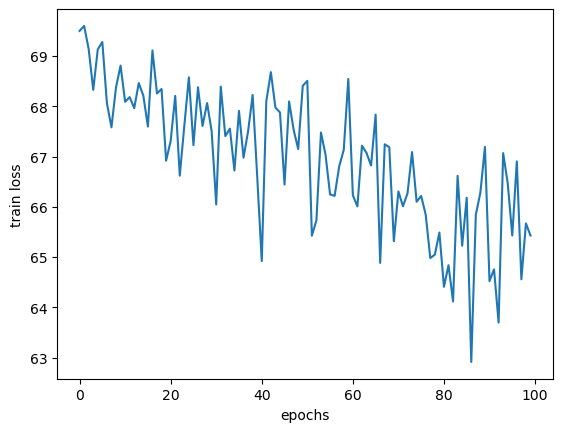

In [4]:
import sys 
sys.path.append('../')

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from utils.dataset import GraphDataset
from torch.utils.data import DataLoader, random_split
from utils.models import GNN, GNN2
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader 

root = Path('../EEGDataset/')
subjects = ['sub-01']
feat_transform = lambda var: extract_features(var, features)
graph_data = GraphDataset(root, subjects, feat_transform)


# Training parameters
lr = 0.001
epochs = 100

# model
model = GNN2(in_channels=12, hid_channels=64)

print('Number of parameters for model: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

samples = np.concatenate([np.arange(0,100), np.arange(400,500)])
sub_data   = graph_data[samples]
print('portion of true samples : ', sum([data.y.item() for data in sub_data])/len(sub_data))
scaler1 = StandardScaler()
scaler1.fit_transform(sub_data)
loader = DataLoader(sub_data, batch_size=2, shuffle=True)

# loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training
losses = []
for _ in range(epochs):
    l = 0 
    for batch in loader:
        model.train()

        pred = model(batch).squeeze()
        loss = loss_fn(pred, batch.y)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)   
        optimizer.step()

        l += loss.item()
    losses += [l]


# Plot training loss
e = range(epochs)
plt.plot(e, losses)
plt.xlabel('epochs')
plt.ylabel('train loss')

In [5]:
valid(loader, model, loss_fn)

Test Error: 
 Accuracy: 56.0%, Avg loss: 64.272839 



64.2728385925293

In [4]:
print(pred)

tensor([0.6776, 0.6808], grad_fn=<SqueezeBackward0>)


In [2]:
import sys 
sys.path.append('../')

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from utils.dataset import GraphDataset
from torch.utils.data import DataLoader, random_split
from utils.models import GNN, GNN2
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

root = Path('../EEGDataset/')
subjects = ['sub-01']
feat_transform = lambda var: extract_features(var, features)
graph_data = GraphDataset(root, subjects, feat_transform)

train_data, test_data = data_split(graph_data, [0.8, 0.2])

# standardize values
scaler = StandardScaler()
scaler.fit_transform(train_data)
scaler.transform(test_data)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)

# Training parameters
lr = 0.001
epochs = 200

# model
model = GNN2(in_channels=12, hid_channels=len(train_data)).to(device)

print('Number of parameters for model: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

# loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))
print('Done!')



Number of parameters for model:  7521
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.677170 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 53.4%, Avg loss: 0.683751 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 55.9%, Avg loss: 0.674225 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 55.1%, Avg loss: 0.674945 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 55.9%, Avg loss: 0.672553 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 56.8%, Avg loss: 0.671183 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.670930 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 55.9%, Avg loss: 0.672579 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 55.1%, Avg loss: 0.674214 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 56.8%, Avg loss: 0.669608 

Epoch 11
-------------------------------


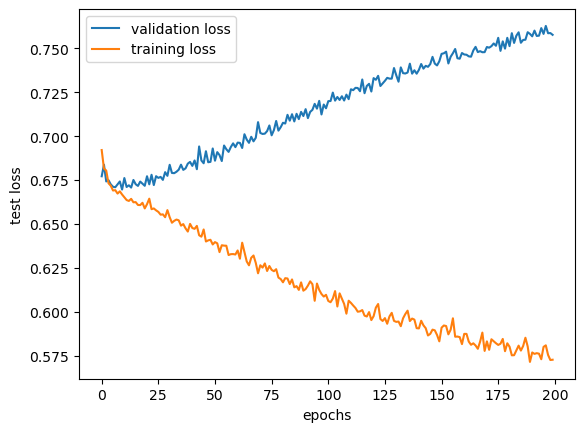

In [3]:
e = range(epochs)
plt.plot(e[:], val_loss[:], tra_loss[:])
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [4]:
valid(train_loader, model, loss_fn, device=device)

Test Error: 
 Accuracy: 73.0%, Avg loss: 8.244153 



8.244152665138245

In [3]:


lengths = [0.8, 0.2]

size_ = len(graph_data)
indices = np.arange(size_)
np.random.shuffle(indices)

splits = np.cumsum([int(size_*l) for l in lengths])[:-1]
indices = np.split(indices, splits)

datas  = [graph_data[ids] for ids in indices]


In [6]:
len(train_loader.dataset)

470